# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from pitch_geo.dataset import keypoints_dataset, tf_dataloaders
from pitch_geo.models.callbacks import LogConfusionMatrixCallback, LogPredictedImages
from pitch_geo.models.metrics import VisiblePrecision, VisibleRecall
import pitch_geo.vis_utils as vis_utils

# Define hyperparameters

In [2]:
IMG_SIZE = 240
BATCH_SIZE = 32
MODEL_PATH = '../best_model/'

# Read the data frame

# Prepare the data loaders

## Read the data frame

In [3]:
train_dataset = keypoints_dataset.get_data(dataset='train')

### Train / validation split

Split the train data into proportion: 85% train set and 15% validation set

In [4]:
train_df, val_df = train_dataset.split(test_size=0.15)

### Create the data loaders

In [5]:
val_data_builder = tf_dataloaders.KeypointsDatasetBuilder(
    data_frame=val_df, 
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)
val_ds = val_data_builder.build()

# The model

## Get the model

The model is built with the `get_model` function. 

In [6]:
model = tf.keras.models.load_model(MODEL_PATH)

# Plots and analysis

## L2 loss of visible points

In [7]:
val_df.reset_index(drop=True, inplace=True)

In [8]:
y_hat = model.predict(val_ds)
y_hat = y_hat.reshape(-1, 3)

visible_points_mask = val_df['vis'] == 1
y_hat_visible = y_hat[visible_points_mask][:, :2]
y_true_visible = val_df[visible_points_mask][['x', 'y']].values

# It would be easier to work with a data frame instead of numpy array
y_hat_df = pd.DataFrame(data=y_hat, columns=['x', 'y', 'vis'])
y_hat_df['kid'] = val_df['kid']

y_hat_df['l2_loss'] = 0
y_hat_df.loc[visible_points_mask, 'l2_loss'] = np.sqrt(np.power(y_true_visible - y_hat_visible, 2).sum(axis=1))

mse_loss = y_hat_df.loc[visible_points_mask, 'l2_loss'].mean()
print(f'RMSE loss of visible points is {mse_loss:0.5f}')

18/18 [==============================] - 8s 177ms/step
RMSE loss of visible points is 0.03512


The loss in pixels for 1920 by 1080 image (loss after rescaling the coordinates) is:

In [9]:
np.sqrt(np.power(y_true_visible * np.array([1920, 1080]) - y_hat_visible * np.array([1920, 1080]), 2).sum(axis=1)).mean()

57.954341317783104

## Distribution of loss per every keypoint ID

It can be seen that the points which are visible more often have lower loss on average.

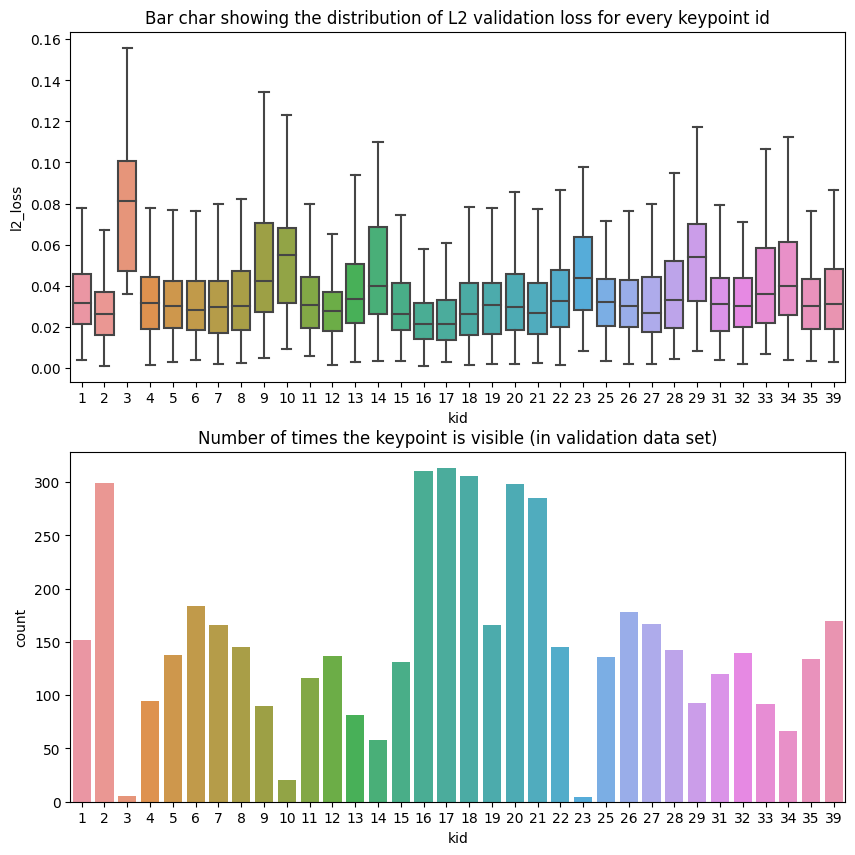

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
sns.boxplot(data=y_hat_df.loc[visible_points_mask], x='kid', y='l2_loss', showfliers = False, ax=ax[0])
sns.countplot(data=val_df[val_df['vis'] != 0], x='kid', ax=ax[1])
ax[0].set_title('Bar char showing the distribution of L2 validation loss for every keypoint id')
ax[1].set_title('Number of times the keypoint is visible (in validation data set)')
plt.show()

### How could the model is at predicting if a point is visible - confusion matrix

In [11]:
cm_callback = LogConfusionMatrixCallback(model, Path('./'), val_ds)

18/18 [==============================] - 2s 128ms/step


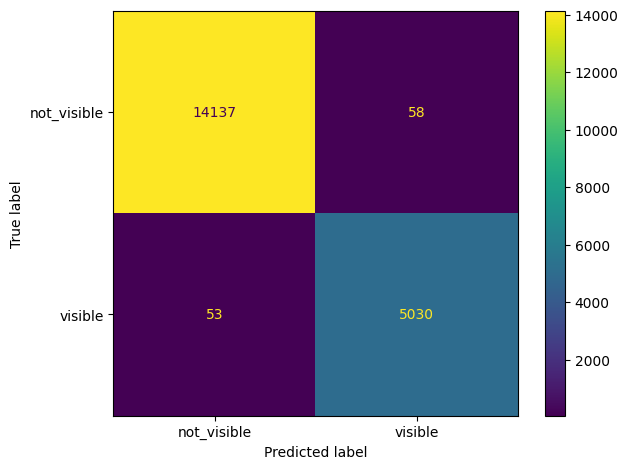

In [12]:
fig = cm_callback.calculate_cm()

### Sample predictions

The plot below is taken from my tensorboard

1/1 [==============================] - 3s 3s/step


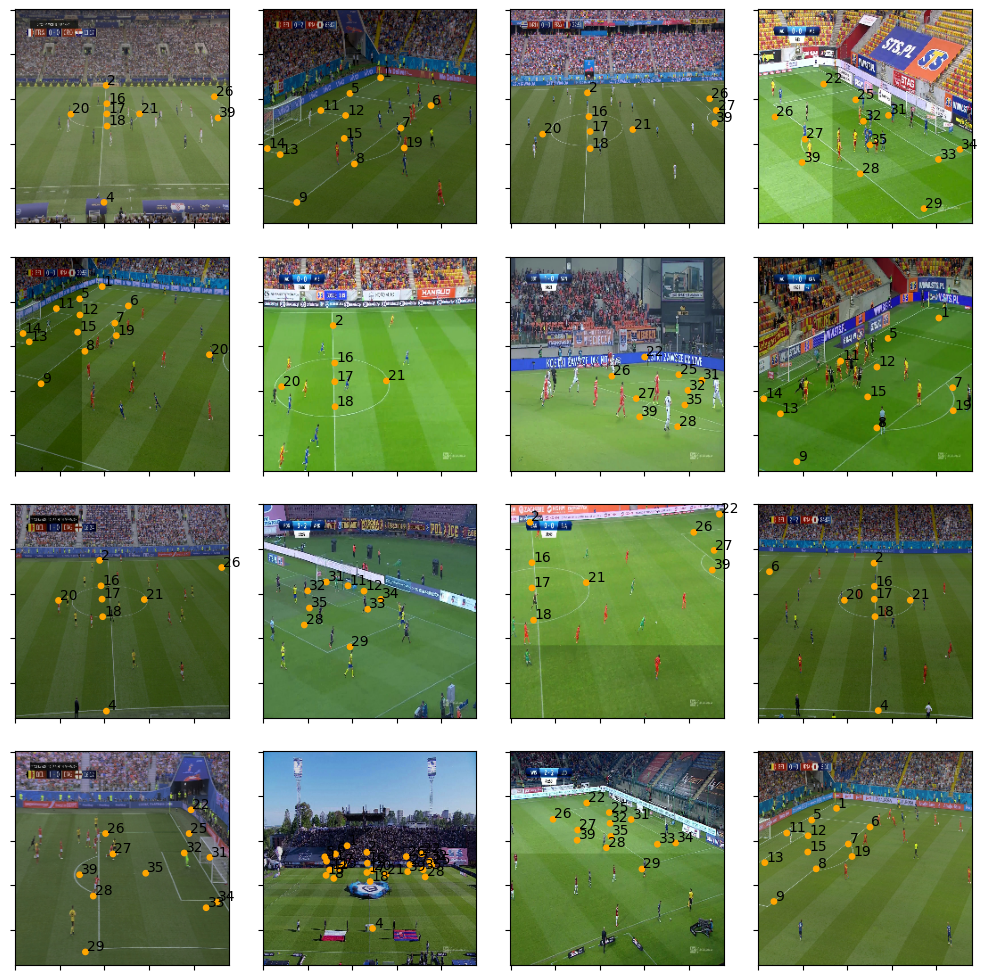

In [13]:
_ = LogPredictedImages(model, Path('./'), val_ds, train_dataset.label_map).predict_and_plot()